# GTSRB classification with CNN - Convolutions

Inspired by the [GTSRB Fidle tutorial](https://fidle.cnrs.fr/w3/)

## 1. Imports

In [1]:
import os
import numpy as np
import time as time
import torch
import torch.nn as nn
import torch.optim as optim
import utils

from torch.utils.data import DataLoader, TensorDataset

## 2. Parameters

In [2]:
enhanced_dir = './prepared_data'
dataset_name = 'set-48x48-L-LHE'
model_name   = utils.ModelName.SMALL
batch_size   = 64
num_epochs   = 64
rng          = np.random.default_rng(int(time.time()))

## 3. Load dataset

x_train.shape = (7841, 48, 48, 1)
y_train.shape = (7841,)
x_test.shape  = (12630, 48, 48, 1)
y_test.shape  = (12630,)


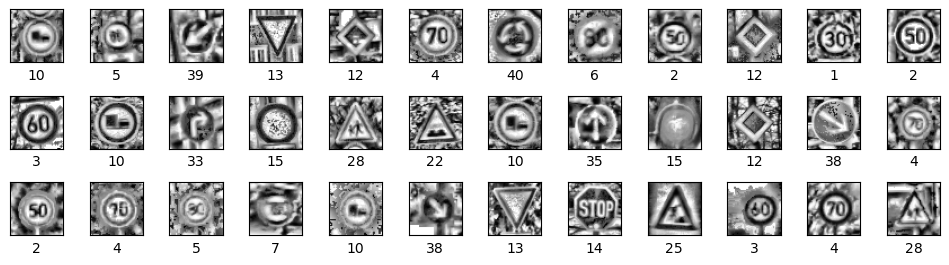

In [3]:
x_train, y_train, x_test, y_test, x_meta, y_meta = utils.load_dataset(enhanced_dir, dataset_name)

print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'x_test.shape  = {x_test.shape}')
print(f'y_test.shape  = {y_test.shape}')
utils.plot_imgs(36, 12, x_train[:36], y_train[:36])

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.int64))
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset  = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int64))
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 4. Get a model

In [4]:
# Get data shape
n, lx, ly, lz = x_train.shape

# Get model
model = utils.get_model(model_name, lx, ly, lz)
display(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'Model moved to device: {device}')

SmallModel(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=19200, out_features=1024, bias=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)

Model moved to device: cuda


## 5. Train the model

In [5]:
# Initialize history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_accuracy = 0

# Create a directory to save the model
os.makedirs(f'./models/', mode=0o750, exist_ok=True)
save_path = f'./models/{model_name}_{str(dataset_name)}_{batch_size}_{num_epochs}.pth'
print(f'Saving model to {save_path}\n')

start_time = time.time()

for epoch in range(num_epochs):
	# Train the model
	model.train()
	train_loss = 0.0
	train_accuracy = 0.0

	for i, data in enumerate(train_loader, 0):
		images, labels = data
		images = images.permute(0, 3, 1, 2) # Change the shape of the images
		images, labels = images.to(device), labels.to(device) # Move to device
		optimizer.zero_grad()
		outputs = model(images)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

	train_losses.append(train_loss / len(train_loader))
	train_accuracies.append(train_accuracy / len(train_dataset))

	# Evaluate the model
	model.eval()
	test_loss = 0
	test_accuracy = 0

	with torch.no_grad():
		for i, data in enumerate(test_loader, 0):
			images, labels = data
			images = images.permute(0, 3, 1, 2) # Change the shape of the images
			images, labels = images.to(device), labels.to(device) # Move to device
			outputs = model(images)
			loss = criterion(outputs, labels)

			test_loss += loss.item()
			test_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

	test_losses.append(test_loss / len(test_loader))
	test_accuracies.append(test_accuracy / len(test_dataset))

	# Show statistics
	if (epoch + 1) % 4 == 0:
		print(f'Epoch {epoch+1}/{num_epochs}\tLoss: {test_losses[-1]:.4f}\tAccuracy: {test_accuracies[-1]:.4f}\tTime: {time.time() - start_time:.2f}s')

	# Save the model if the accuracy is better
	if test_accuracy > best_accuracy:
		torch.save(model.state_dict(), save_path)
		best_accuracy = test_accuracy

Saving model to ./models/ModelName.SMALL_set-48x48-L-LHE_64_64.pth

Epoch 4/64	Loss: 3.2383	Accuracy: 0.5652	Time: 34.83s
Epoch 8/64	Loss: 3.2183	Accuracy: 0.5819	Time: 66.03s
Epoch 12/64	Loss: 3.1762	Accuracy: 0.6249	Time: 97.49s
Epoch 16/64	Loss: 3.1461	Accuracy: 0.6549	Time: 129.36s
Epoch 20/64	Loss: 3.0893	Accuracy: 0.7124	Time: 160.40s
Epoch 24/64	Loss: 3.0823	Accuracy: 0.7195	Time: 191.39s
Epoch 28/64	Loss: 3.0517	Accuracy: 0.7492	Time: 223.94s
Epoch 32/64	Loss: 3.0482	Accuracy: 0.7540	Time: 254.97s
Epoch 36/64	Loss: 3.0302	Accuracy: 0.7721	Time: 286.43s
Epoch 40/64	Loss: 3.0251	Accuracy: 0.7762	Time: 317.35s
Epoch 44/64	Loss: 3.0263	Accuracy: 0.7747	Time: 348.64s
Epoch 48/64	Loss: 2.9790	Accuracy: 0.8231	Time: 379.11s
Epoch 52/64	Loss: 2.9771	Accuracy: 0.8253	Time: 409.79s
Epoch 56/64	Loss: 2.9376	Accuracy: 0.8634	Time: 440.67s
Epoch 60/64	Loss: 2.9394	Accuracy: 0.8607	Time: 471.01s
Epoch 64/64	Loss: 2.9354	Accuracy: 0.8658	Time: 501.45s


## 6. Evaluate the model

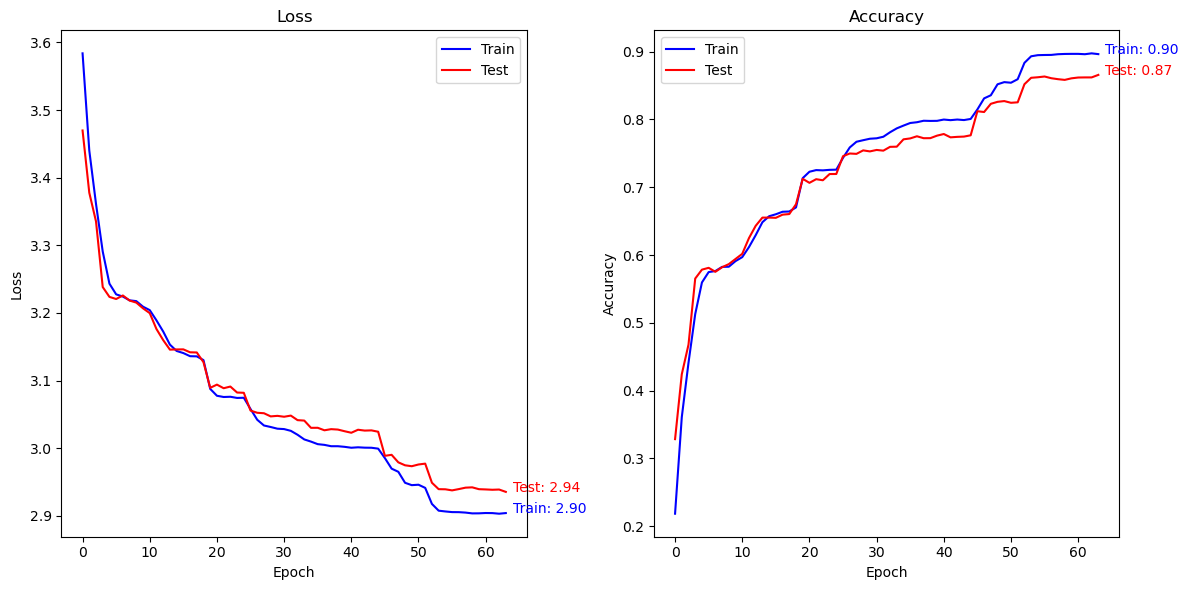

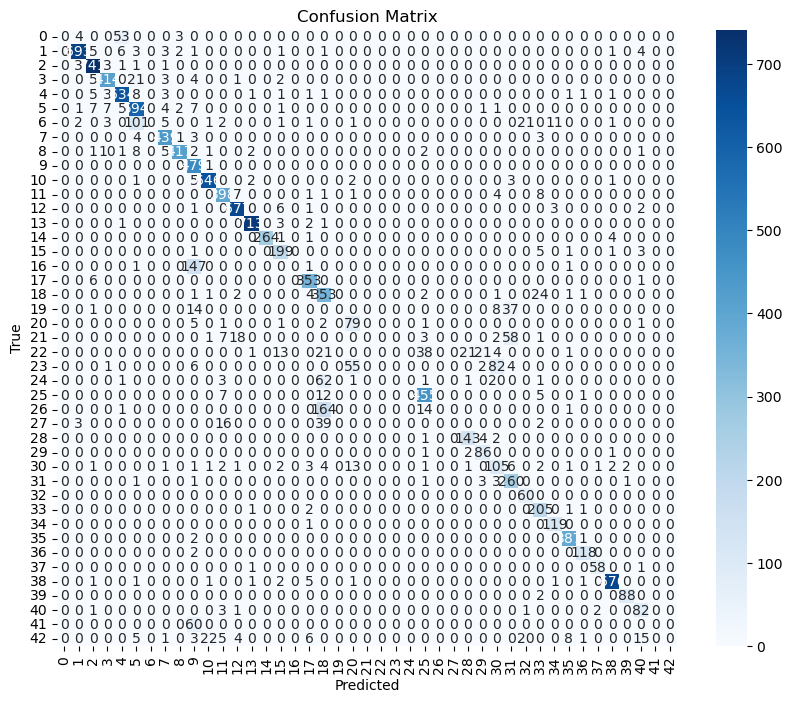

In [6]:
# Loss and accuracy history
utils.plot_history(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

# Confusion matrix
all_labels = []
all_preds = []

with torch.no_grad():
	for i, data in enumerate(test_loader, 0):
		images, labels = data
		images = images.permute(0, 3, 1, 2) # Change the shape of the images
		images, labels = images.to(device), labels.to(device) # Move to device
		outputs = model(images)
		all_labels.extend(labels.cpu().numpy())
		all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())

utils.plot_confusion_matrix(all_labels, all_preds)